# Multivariate Linear Models

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


###### Figure 5.1

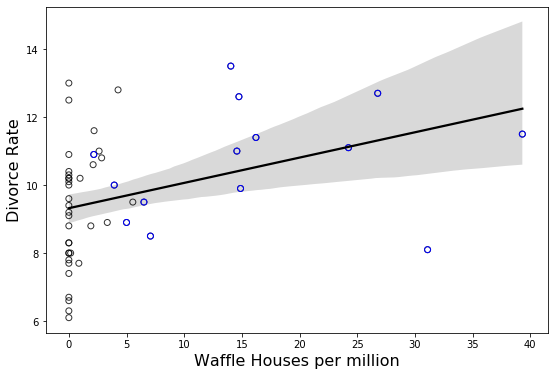

In [3]:
d = d.assign(WHperMillion = lambda x: x.WaffleHouses / x.Population)
plt.figure(figsize=(9,6))
sns.regplot('WHperMillion', y='Divorce', data=d, ci=89, color='black', scatter_kws={'facecolor':'none'})
plt.scatter(d.WHperMillion[d.South==1], y=d.Divorce[d.South==1], color='b', facecolors='none')
plt.xlabel('Waffle Houses per million', fontsize=16)
plt.ylabel('Divorce Rate', fontsize=16);

### Spurious Association

###### Code 5.1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1146.09draws/s]


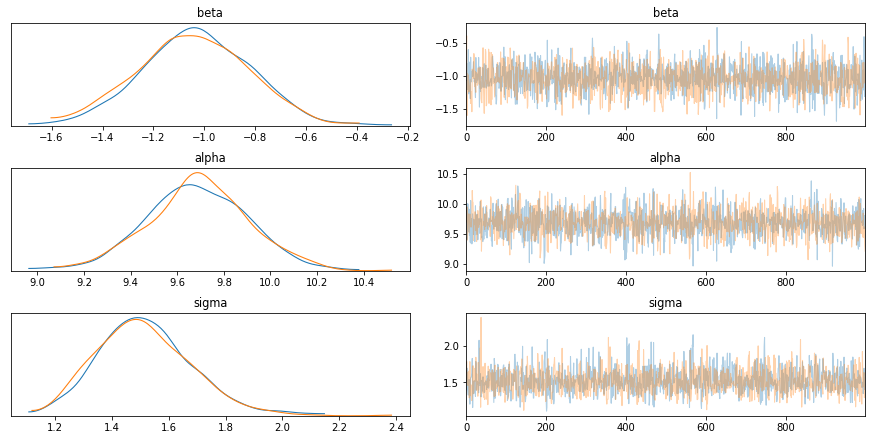

In [4]:
d = (
    d
    .assign(Marriage_s = lambda x: (x.Marriage - x.Marriage.mean()) / x.Marriage.std(),
            MedianAgeMarriage_s = lambda x: (x.MedianAgeMarriage - x.MedianAgeMarriage.mean()) / x.MedianAgeMarriage.std()
           )
)

with pm.Model() as m5_1:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.MedianAgeMarriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)
    

pm.plot_trace(trace_5_1, varnames=['~mu']);

###### Code 5.2

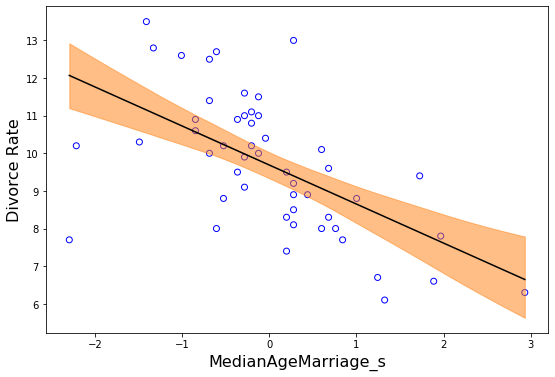

In [5]:
plt.figure(figsize=(9,6))
plt.scatter(d.MedianAgeMarriage_s, d.Divorce, facecolors='none', color='b')
sns.lineplot(d.MedianAgeMarriage_s, trace_5_1['mu'].mean(axis=0), color='black')
pm.plot_hpd(d.MedianAgeMarriage_s, trace_5_1['mu'], credible_interval=0.89)
plt.xlabel('MedianAgeMarriage_s', fontsize=16)
plt.ylabel('Divorce Rate', fontsize=16);

###### Code 5.3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1338.56draws/s]


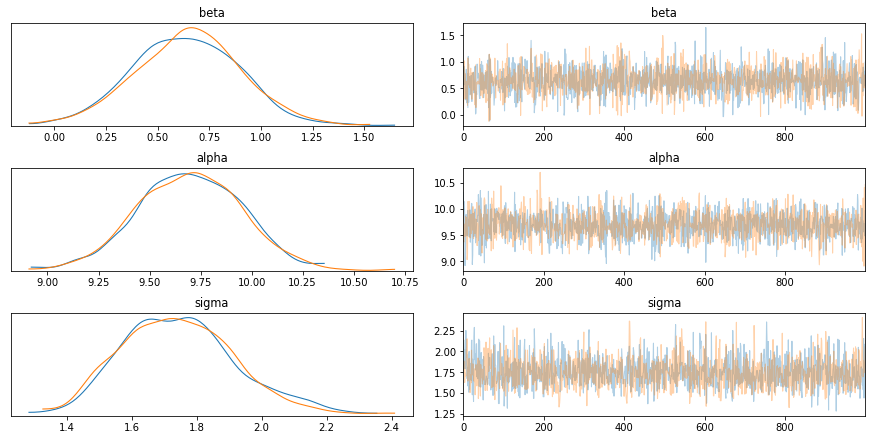

In [7]:
with pm.Model() as m5_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.Marriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000, tune=1000)
    

pm.plot_trace(trace_5_2, varnames=['~mu']);

###### Figure 5.2

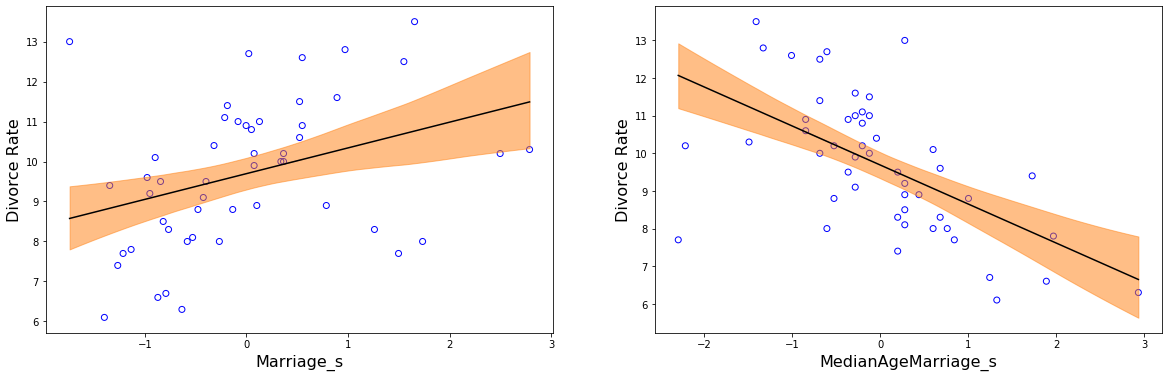

In [8]:
fig, (ax2, ax1) = plt.subplots(1,2, figsize=(20,6))
ax1.scatter(d.MedianAgeMarriage_s, d.Divorce, facecolors='none', color='b')
sns.lineplot(d.MedianAgeMarriage_s, trace_5_1['mu'].mean(axis=0), color='black', ax=ax1)
pm.plot_hpd(d.MedianAgeMarriage_s, trace_5_1['mu'], credible_interval=0.89, ax=ax1)
ax1.set_xlabel('MedianAgeMarriage_s', fontsize=16)
ax1.set_ylabel('Divorce Rate', fontsize=16)


ax2.scatter(d.Marriage_s, d.Divorce, facecolors='none', color='b')
sns.lineplot(d.Marriage_s, trace_5_2['mu'].mean(axis=0), color='black', ax=ax2)
pm.plot_hpd(d.Marriage_s, trace_5_2['mu'], credible_interval=0.89, ax=ax2)
ax2.set_xlabel('Marriage_s', fontsize=16)
ax2.set_ylabel('Divorce Rate', fontsize=16);

###### Code 5.4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, bA, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 844.73draws/s]


        mean     sd  hpd_5.5%  hpd_94.5%
bA[0] -0.112  0.300    -0.572      0.364
bA[1] -1.122  0.306    -1.624     -0.654
alpha  9.681  0.215     9.357     10.025
sigma  1.530  0.165     1.257      1.766


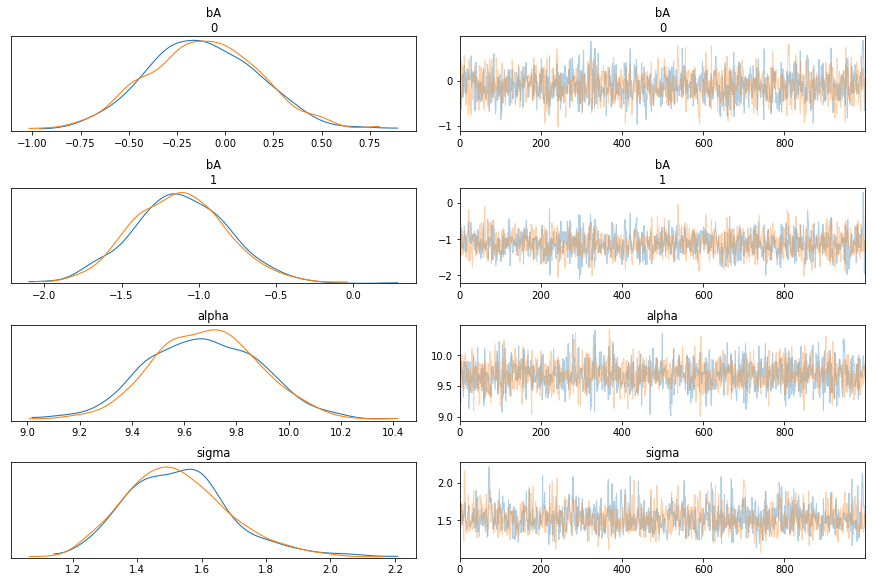

In [9]:
with pm.Model() as m5_3:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)
    
print(pm.stats.summary(trace_5_3, kind='stats', credible_interval=0.89, varnames=['~mu']))
pm.plot_trace(trace_5_3, varnames=['~mu']);

###### Code 5.5

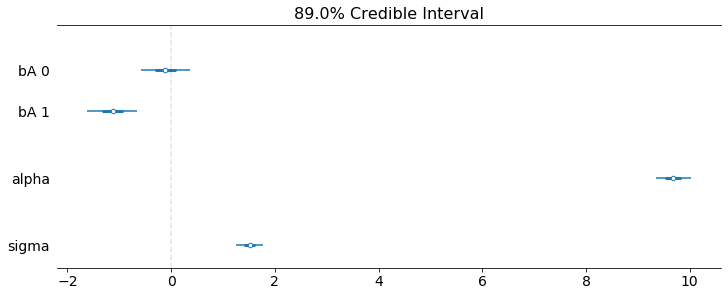

In [10]:
pm.forestplot(trace_5_3, varnames=['~mu'], credible_interval=0.89, combined=True, figsize=(10,4))
plt.axvline(color='black', alpha=0.1, linestyle='--');

###### Code 5.6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1390.41draws/s]


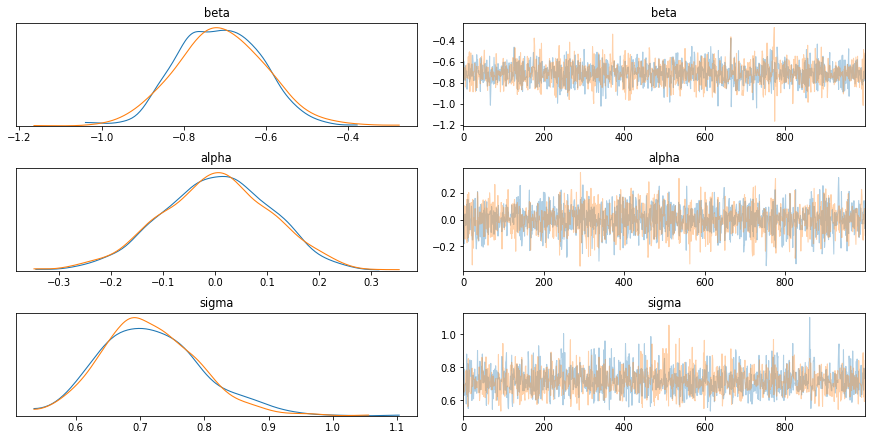

In [11]:
with pm.Model() as m5_4:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.MedianAgeMarriage_s)
    marriage = pm.Normal('marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)
    

pm.plot_trace(trace_5_4, varnames=['~mu']);

###### Code 5.7

In [12]:
mu_pred = trace_5_4['mu'].mean(axis=0)
residuals = d.Marriage_s - mu_pred

###### Code 5.8

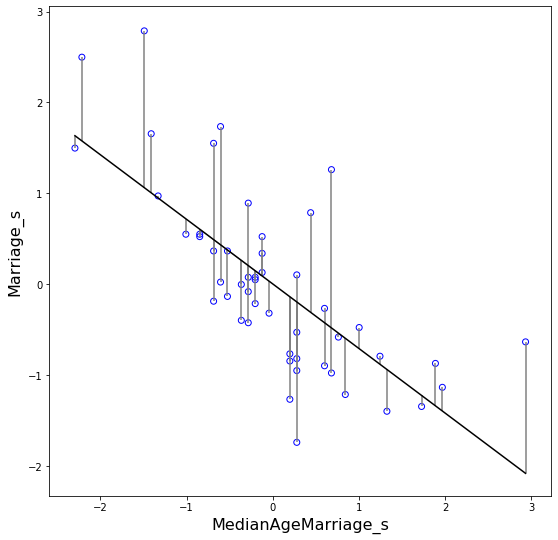

In [13]:
plt.figure(figsize=(9,9))
sns.lineplot(d.MedianAgeMarriage_s, mu_pred, color='black')
plt.scatter(d.MedianAgeMarriage_s, d.Marriage_s, color='b', facecolors='none')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, color='grey')
plt.xlabel('MedianAgeMarriage_s', fontsize=16)
plt.ylabel('Marriage_s', fontsize=16);

###### Figure 5.4

In [14]:
with pm.Model() as m_f5_4:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.Marriage_s)
    median_age = pm.Normal('medianage', mu=mu, sd=sigma, observed=d.MedianAgeMarriage_s)
    trace_f5_4 = pm.sample(1000, tune=1000)

mu_pred_age = trace_5_4['mu'].mean(axis=0)
residuals_age = d.MedianAgeMarriage_s - mu_pred_age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1269.50draws/s]


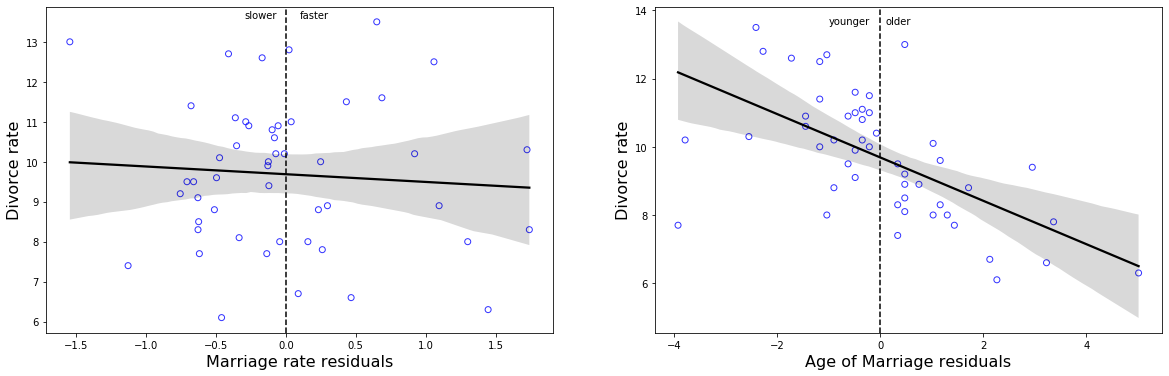

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.regplot(residuals, d.Divorce, color='black', scatter_kws={'facecolors':'none', 'color':'b'},ax=ax1)
ax1.axvline(color='black', linestyle='--')
ax1.annotate('slower', xy=(-0.3, d.Divorce.max() + 0.1))
ax1.annotate('faster', xy=(0.1, d.Divorce.max() + 0.1))
ax1.set_xlabel('Marriage rate residuals', fontsize=16)
ax1.set_ylabel('Divorce rate', fontsize=16)

sns.regplot(residuals_age, d.Divorce, color='black', scatter_kws={'facecolors':'none', 'color':'b'},ax=ax2)
ax2.axvline(color='black', linestyle='--')
ax2.annotate('younger', xy=(-1, d.Divorce.max() + 0.1))
ax2.annotate('older', xy=(0.1, d.Divorce.max() + 0.1))
ax2.set_xlabel('Age of Marriage residuals', fontsize=16)
ax2.set_ylabel('Divorce rate', fontsize=16);

###### Code 5.9

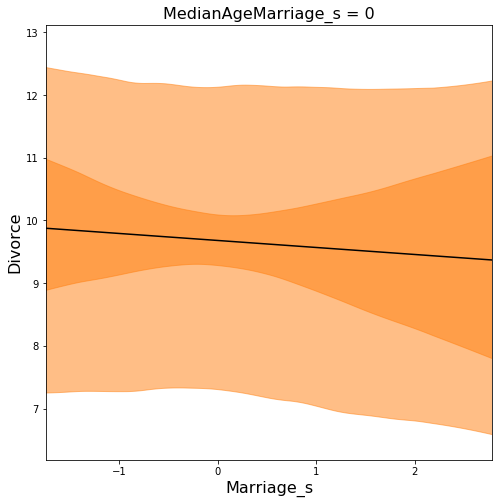

In [16]:
a_avg = d.MedianAgeMarriage_s.mean()
r_seq = np.linspace(-3, 3, 30)

mu_pred = trace_5_3['alpha'] + trace_5_3['bA'][:,0] * r_seq[:,None] + trace_5_3['bA'][:,1] * a_avg
mu_mean = mu_pred.mean(axis=1)
mu_pi = np.apply_along_axis(lambda x: np.percentile(x, [5.5, 94.5]), axis=1, arr=mu_pred)
r_sim = np.random.normal(mu_pred, trace_5_3['sigma'])
r_pi = np.apply_along_axis(lambda x: np.percentile(x, [5.5, 94.5]), axis=1, arr=r_sim)

# Plot
plt.figure(figsize=(8,8))
sns.lineplot(r_seq, mu_mean, color='black')
pm.plot_hpd(r_seq, mu_pred.T)
pm.plot_hpd(r_seq, r_pi.T)
plt.xlim([d.Marriage_s.min(), d.Marriage_s.max()])
plt.xlabel('Marriage_s', fontsize=16)
plt.ylabel('Divorce', fontsize=16)
plt.title('MedianAgeMarriage_s = 0', fontsize=16);

###### Code 5.10

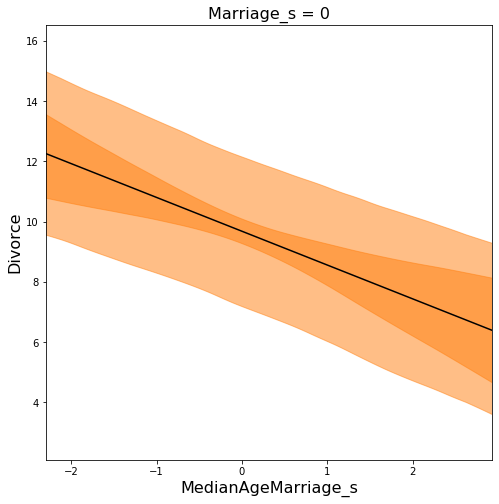

In [17]:
r_avg = d.Marriage_s.mean()
a_seq = np.linspace(-3, 3.5, 30)

mu_pred = trace_5_3['alpha'] + trace_5_3['bA'][:,0] * r_avg + trace_5_3['bA'][:,1] * a_seq[:,None]
mu_mean = mu_pred.mean(axis=1)
mu_pi = np.apply_along_axis(lambda x: np.percentile(x, [5.5, 94.5]), axis=1, arr=mu_pred)
r_sim = np.random.normal(mu_pred, trace_5_3['sigma'])
r_pi = np.apply_along_axis(lambda x: np.percentile(x, [5.5, 94.5]), axis=1, arr=r_sim)

# Plot
plt.figure(figsize=(8,8))
sns.lineplot(a_seq, mu_mean, color='black')
pm.plot_hpd(a_seq, mu_pred.T)
pm.plot_hpd(a_seq, r_pi.T)
plt.xlim([d.MedianAgeMarriage_s.min(), d.MedianAgeMarriage_s.max()])
plt.xlabel('MedianAgeMarriage_s', fontsize=16)
plt.ylabel('Divorce', fontsize=16)
plt.title('Marriage_s = 0', fontsize=16);

###### Code 5.11

In [18]:
mu_pred = trace_5_3['mu']

divorce_sim = pm.sample_posterior_predictive(trace_5_3, model=m5_3)
divorce_hpd = pm.hpd(divorce_sim['divorce'])

100%|██████████| 2000/2000 [00:03<00:00, 561.85it/s]


###### Code 5.12

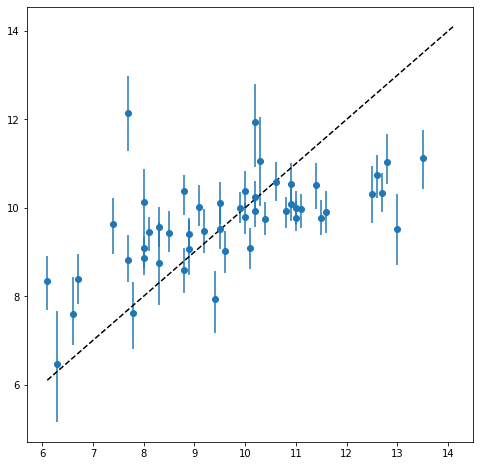

In [19]:
mu_hpd = pm.hpd(mu_pred, credible_interval=0.89)
plt.figure(figsize=(8,8))
plt.errorbar(d.Divorce, divorce_sim['divorce'].mean(0), yerr=np.abs(divorce_sim['divorce'].mean(0) - mu_hpd.T), fmt='C0o')
x = np.arange(d.Divorce.min(),d.Divorce.max()+1)
plt.plot(x,x, linestyle='--', color='black')


###### Code 5.13

###### Code 5.14

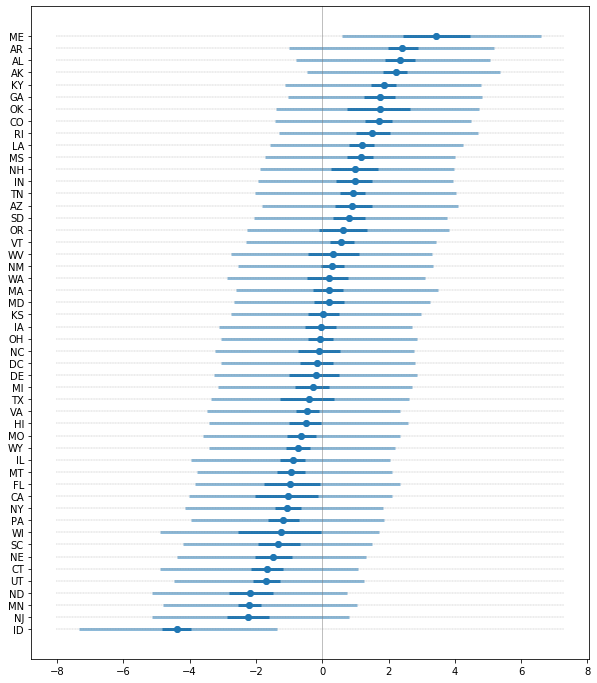

In [20]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(axis=0)

idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, d.Loc.nunique())

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(mu_pred.mean(axis=0) - mu_hpd.T),
             fmt='C0o', lw=3)
xerr_d=np.abs(mu_pred.mean(axis=0) - divorce_hpd.T)
plt.errorbar(residuals[idx], y_points, 
             xerr=xerr_d,
             fmt='C0o', lw=3, alpha=0.5)
plt.axvline(color='grey', lw=0.5)
plt.hlines(y_points, plt.axis()[0], plt.axis()[1], ls='--', color='grey', lw=0.3)
plt.yticks(y_points, y_label);

###### Code 5.15

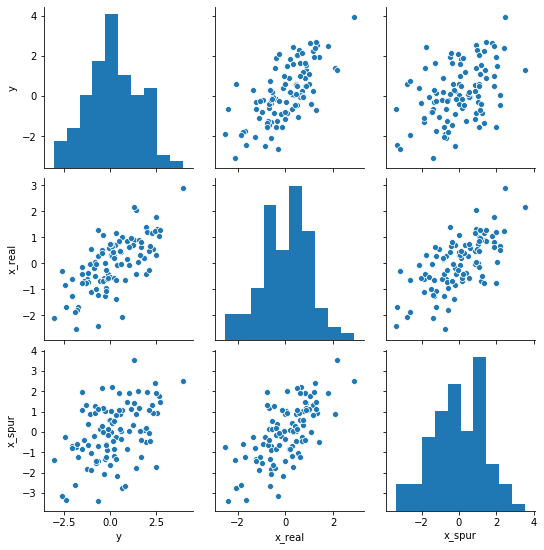

In [21]:
N = 100
x_real = np.random.normal(size=N)
x_spur = np.random.normal(loc=x_real)
y = np.random.normal(loc=x_real)
d = pd.DataFrame([y, x_real, x_spur], index=['y', 'x_real', 'x_spur']).T

sns.pairplot(d);

### Masked relationship

###### Code 5.16

In [22]:
d = pd.read_csv('../../data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


###### Code 5.17

In [22]:
# Throws error of Bad Initial Energy
with pm.Model() as m5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * d['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_5_17 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_5, kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
kcal   NaN


ParallelSamplingError: Bad initial energy

###### Code 5.18

In [23]:
d['neocortex.perc'].head(10)

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
5    64.54
6    64.54
7    67.64
8      NaN
9    68.85
Name: neocortex.perc, dtype: float64

###### Code 5.19

In [24]:
dcc = d.dropna().copy()

###### Code 5.20

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 5 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 391.32draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a215e3e50>,
      dtype=object)

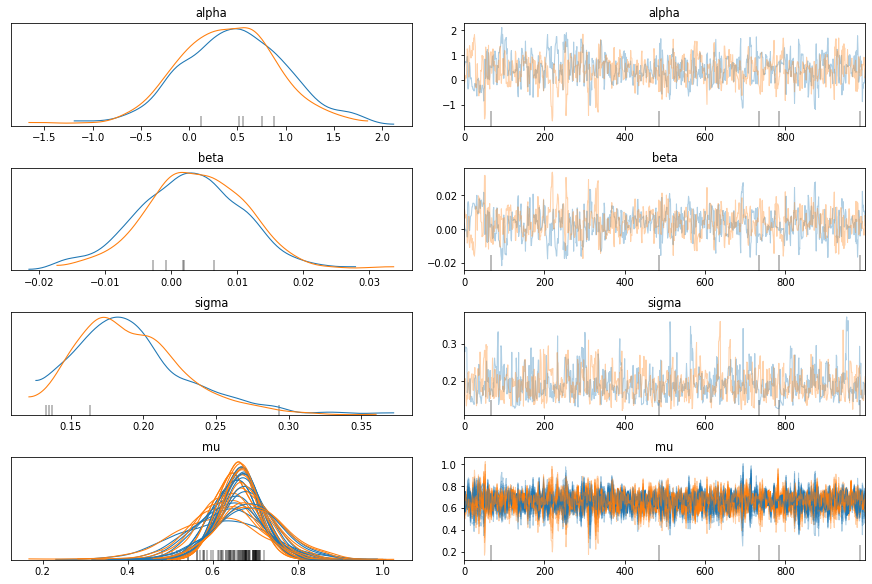

In [25]:
with pm.Model() as m5_5:
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    alpha = pm.Normal('alpha', mu=0, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1)
    mu = pm.Deterministic('mu', alpha + bn * dcc['neocortex.perc'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000, tune=1000)

pm.traceplot(trace_5_5)

###### Code 5.21

In [26]:
pm.stats.summary(trace_5_5, kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,0.424,0.542,-0.654,1.407
beta,0.003,0.008,-0.011,0.019
sigma,0.192,0.039,0.126,0.262
mu[0],0.616,0.110,0.404,0.811
mu[1],0.648,0.053,0.557,0.752
mu[2],0.648,0.053,0.557,0.752
mu[3],0.659,0.047,0.573,0.750
mu[4],0.663,0.048,0.574,0.755
mu[5],0.628,0.084,0.453,0.767
mu[6],0.638,0.066,0.523,0.766


###### Code 5.22

In [27]:
trace_5_5['beta'].mean() * ( 76 - 55)

0.07308213798226282

###### Code 5.23

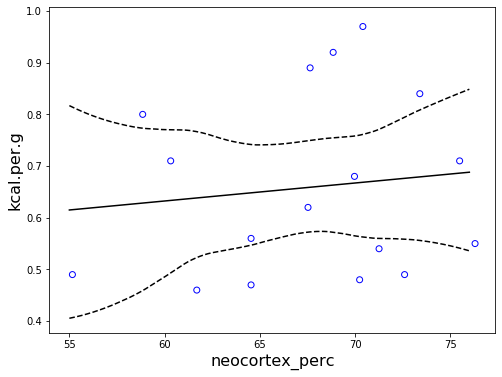

In [28]:
np_seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['alpha'] + trace_5_5['beta'] * np_seq[:, None]

plt.figure(figsize=(8,6))
plt.scatter(dcc['neocortex.perc'], dcc['kcal.per.g'], facecolors='none', edgecolors='b')
plt.plot(np_seq, mu_pred.mean(axis=1), color='k')
pm.plot_hpd(np_seq, mu_pred.T, fill_kwargs={'alpha': 0}, plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})
plt.xlabel('neocortex_perc', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

###### Code 5.24

In [29]:
dcc['log_mass'] = np.log(dcc.mass)

###### Code 5.25

In [30]:
with pm.Model() as m5_6:
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    alpha = pm.Normal('alpha', mu=0, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1)
    mu = pm.Deterministic('mu', alpha + bn * dcc.log_mass)
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_6, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1689.98draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
alpha,0.706,0.056,0.617,0.792
beta,-0.033,0.024,-0.070,0.005
sigma,0.182,0.038,0.124,0.233


###### Code 5.26

In [31]:
with pm.Model() as m5_7:
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    alpha = pm.Normal('alpha', mu=0, sd=100)
    bn = pm.Normal('beta', mu=0, sd=1, shape=2)
    mu = pm.Deterministic('mu', alpha + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc.log_mass)
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_7, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 3 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 239.73draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%
alpha,-1.098,0.579,-2.035,-0.218
beta[0],0.028,0.009,0.014,0.042
beta[1],-0.097,0.028,-0.141,-0.053
sigma,0.140,0.030,0.095,0.183


###### Code 5.27

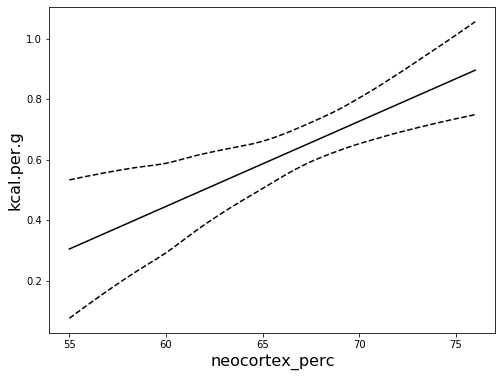

In [32]:
mean_log_mass = dcc.log_mass.mean()
np_seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['alpha'] + trace_5_7['beta'][:,0] * np_seq[:, None] + trace_5_7['beta'][:,1] * mean_log_mass

plt.figure(figsize=(8,6))
plt.plot(np_seq, mu_pred.mean(axis=1), color='k')
pm.plot_hpd(np_seq, mu_pred.T, fill_kwargs={'alpha': 0}, plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})
plt.xlabel('neocortex_perc', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

###### Code 5.28

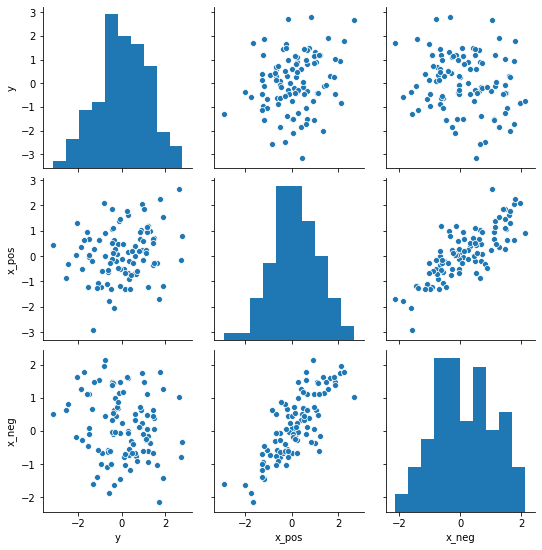

In [33]:
N = 100
rho = 0.7
x_pos = np.random.normal(size=N)
x_neg = np.random.normal(rho*x_pos, (1 - rho**2)**0.5)
y = np.random.normal(x_pos - x_neg)
d = pd.DataFrame([y, x_pos, x_neg], index=['y', 'x_pos', 'x_neg']).T

sns.pairplot(d);

### When adding variables hurts

###### Code 5.29

In [34]:
N = 100
height = np.random.normal(10, 2, N)
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)
d = pd.DataFrame([height, leg_prop, leg_left, leg_right], index=['height', 'leg_prop', 'leg_left', 'leg_right']).T

###### Code 5.30

In [35]:
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    a = pm.Normal('a', mu=10, sd=100)
    mu = pm.Deterministic('mu', a + bl*d.leg_left + br*d.leg_right)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_8 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_8, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, br, bl, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 4000/4000 [02:01<00:00, 32.91draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hpd_5.5%,hpd_94.5%
bl,-0.702,2.283,-4.608,2.713
br,2.717,2.281,-0.865,6.465
a,0.887,0.343,0.338,1.406
sigma,0.684,0.053,0.607,0.765


###### Code 5.31

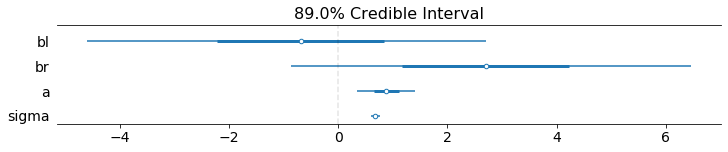

In [36]:
pm.forestplot(trace_5_8, varnames=['~mu'], credible_interval=0.89, combined=True, figsize=(10,2))
plt.axvline(color='k', alpha=0.1, linestyle='--');

###### Code 5.32

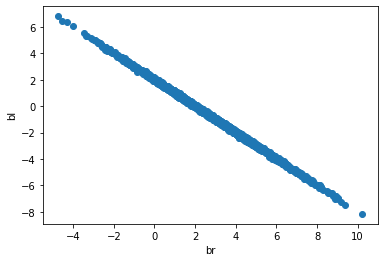

In [37]:
plt.scatter(trace_5_8['br'], trace_5_8['bl'])
plt.xlabel('br')
plt.ylabel('bl');

###### Code 5.33

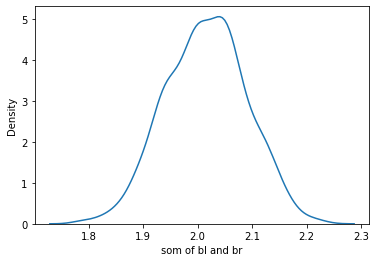

In [38]:
sns.kdeplot(trace_5_8['br'] + trace_5_8['bl'])
plt.xlabel('som of bl and br')
plt.ylabel('Density');

###### Code 5.34

In [39]:
with pm.Model() as m5_9:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bl = pm.Normal('bl', mu=2, sd=10)
    a = pm.Normal('a', mu=10, sd=100)
    mu = pm.Deterministic('mu', a + bl*d.leg_left)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_34 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_9, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:06<00:00, 587.15draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
bl,2.015,0.077,1.885,2.131
a,0.894,0.351,0.341,1.457
sigma,0.687,0.049,0.603,0.757


###### Code 5.35

In [40]:
d = pd.read_csv('../../data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


###### Code 5.36

In [41]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bf = pm.Normal('bf', mu=0, sd=1)
    a = pm.Normal('a', mu=0.6, sd=10)
    mu = pm.Deterministic('mu', a + bf * d['perc.fat'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)
    
# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bf = pm.Normal('bf', mu=0, sd=1)
    a = pm.Normal('a', mu=0.6, sd=10)
    mu = pm.Deterministic('mu', a + bf * d['perc.lactose'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 812.86draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 675.31draws/s] 


In [42]:
pm.stats.summary(trace_5_10, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
bf,0.010,0.001,0.008,0.012
a,0.302,0.039,0.235,0.360
sigma,0.080,0.012,0.062,0.099


In [43]:
pm.stats.summary(trace_5_11, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
bf,-0.011,0.001,-0.012,-0.009
a,1.166,0.045,1.092,1.235
sigma,0.067,0.010,0.053,0.083


###### Code 5.37

In [44]:
with pm.Model() as m5_12:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bf = pm.Normal('bf', mu=0, sd=1, shape=2)
    a = pm.Normal('a', mu=0.6, sd=10)
    mu = pm.Deterministic('mu', a + bf[0] * d['perc.fat'] + bf[1] * d['perc.lactose'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_12, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains, 7 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 208.50draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8989920939597194, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%
bf[0],0.002,0.003,-0.002,0.006
bf[1],-0.009,0.003,-0.013,-0.005
a,1.022,0.225,0.659,1.338
sigma,0.069,0.010,0.053,0.083


###### Code 5.38

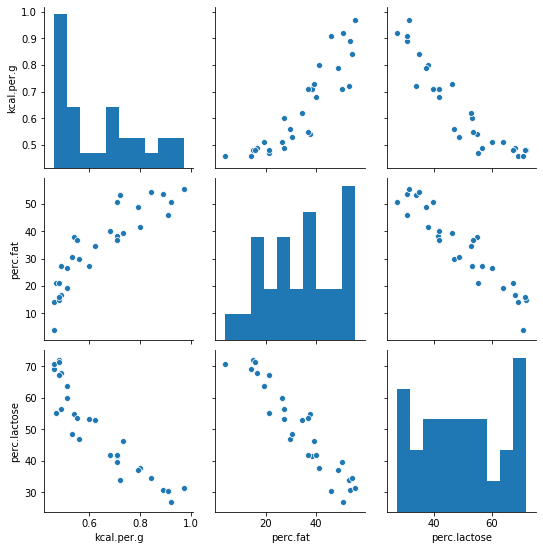

In [45]:
sns.pairplot(d[['kcal.per.g','perc.fat','perc.lactose']]);

###### Code 5.39

In [46]:
d.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

###### Code 5.40

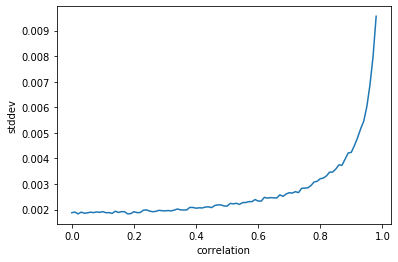

In [47]:
def sim_coll(r = 0.9):
    d['x'] = np.random.normal(r * d['perc.fat'], np.sqrt((1 - r**2) * d['perc.fat'].var()))
    X = np.column_stack((d['perc.fat'], d['x']))
    m = smf.OLS(d['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5

def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = np.vectorize(rep_sim_coll)(r_seq)
plt.plot(r_seq, stddev)
plt.xlabel('correlation')
plt.ylabel('stddev');

###### Code 5.41

In [48]:
N = 100
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(N, 0.5 - treatment*0.4)
h1 = h0 + np.random.normal(5 - 3*fungus)
d = pd.DataFrame([h0, h1, treatment, fungus], index=['h0', 'h1', 'treatment', 'fungus']).T

d.head()

,h0,h1,treatment,fungus
0,12.301951,-79.738344,0.0,32.0
1,12.447273,-123.592320,0.0,47.0
2,5.967346,-134.706737,0.0,49.0
3,4.332732,-131.428163,0.0,47.0
4,8.633275,-149.612788,0.0,54.0


###### Code 5.42

In [49]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d.h1)
    trace_5_13 = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_13, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, bh, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 269.90draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,6.877,1.239,4.796,8.777
bh,1.005,0.046,0.936,1.080
bt,-1.559,0.935,-3.042,-0.024
bf,-3.041,0.023,-3.079,-3.005
sigma,1.038,0.072,0.933,1.158


###### Code 5.43

In [50]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d.h1)
    trace_5_14 = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_14, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, bh, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.07draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,-142.699,4.488,-150.344,-135.918
bh,1.063,0.439,0.257,1.671
bt,116.433,1.904,113.625,119.716
sigma,9.905,0.087,9.800,10.000


### Categorical Variables

###### Code 5.44

In [51]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


###### Code 5.45

In [52]:
with pm.Model() as m5_15:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    a = pm.Normal('a', mu=178, sd=100)
    bm = pm.Normal('bm', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + bm * d.male)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_15 = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_15, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1193.77draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,134.894,1.605,132.186,137.227
bm,7.196,2.293,3.607,10.827
sigma,27.403,0.873,26.028,28.736


###### Code 5.46

In [53]:
mu_male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu_male)

array([139.28145656, 145.44735826])

###### Code 5.47

In [54]:
with pm.Model() as m5_15b:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    af = pm.Normal('af', mu=178, sd=100)
    am = pm.Normal('am', mu=178, sd=100)
    mu = pm.Deterministic('mu', af * (1 - d.male) + am * d.male)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_47 = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_15b, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [am, af, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1572.97draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
af,134.597,1.625,132.218,137.466
am,142.314,1.782,139.334,145.032
sigma,27.401,0.860,26.065,28.806


###### Code 5.48

In [55]:
d = pd.read_csv('../../data/milk.csv', sep=';')
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

###### Code 5.49

In [56]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].values

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

###### Code 5.50

In [57]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

###### Code 5.51

In [58]:
with pm.Model() as m5_16:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    a = pm.Normal('a', mu=0.6, sd=10)
    b_nwm = pm.Normal('b.NWM', mu=0, sd=1)
    b_owm = pm.Normal('b.OWM', mu=0, sd=1)
    b_s = pm.Normal('b.S', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + b_nwm * d['clade.NWM'] + b_owm * d['clade.OWM'] + b_s * d['clade.S'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_16, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b.S, b.OWM, b.NWM, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1390.36draws/s]
The acceptance probability does not match the target. It is 0.879983448400236, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.546,0.045,0.467,0.609
b.NWM,0.167,0.063,0.076,0.276
b.OWM,0.241,0.069,0.134,0.348
b.S,-0.039,0.073,-0.153,0.075
sigma,0.129,0.018,0.101,0.158


###### Code 5.52

In [59]:
mu_ape = trace_5_51['a']
mu_nwm = trace_5_51['a'] + trace_5_51['b.NWM']
mu_owm = trace_5_51['a'] + trace_5_51['b.OWM']
mu_s = trace_5_51['a'] + trace_5_51['b.S']

(
    pd.DataFrame([mu_ape, mu_nwm, mu_owm, mu_s], index=['mu_ape', 'mu_nwm', 'mu_owm', 'mu_s'])
    .T
    .describe(percentiles=[0.055, 0.945])
    .loc[['mean', 'std', '5.5%', '94.5%'],:]
    .T
    .round(2)
)

,mean,std,5.5%,94.5%
mu_ape,0.55,0.05,0.48,0.62
mu_nwm,0.71,0.04,0.64,0.78
mu_owm,0.79,0.05,0.70,0.87
mu_s,0.51,0.06,0.42,0.60


###### Code 5.53

In [60]:
diff_NMW_OWM = mu_nwm - mu_owm
np.percentile(diff_NMW_OWM, q=[2.5, 50, 97.5])

array([-0.2077066 , -0.07419149,  0.06131463])

###### Code 5.54

In [61]:
d['clade_id'] = pd.Categorical(d['clade']).codes

###### Code 5.55

In [62]:
with pm.Model() as m5_16_alt:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    kcal_per_g = pm.Normal('kcal_per_g', mu=a[d['clade_id'].values], sd=sigma, observed=d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000)
    
pm.stats.summary(trace_5_16_alt, credible_interval=0.89, kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1822.69draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a[0],0.546,0.043,0.478,0.616
a[1],0.715,0.044,0.646,0.786
a[2],0.787,0.052,0.707,0.870
a[3],0.507,0.057,0.422,0.597
sigma,0.130,0.020,0.100,0.160


### Ordinary Least Squares

###### Code 5.56

###### Code 5.57

###### Code 5.58

###### Code 5.59

###### Code 5.60

###### Code 5.61

###### Code 5.62

In [63]:
data  = pd.read_csv('../../data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

In [64]:
import sys, IPython, scipy, matplotlib, platform, statsmodels
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1


